# Convert model to onnx

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

from os import path
import sys
sys.path.append(path.abspath('..'))

In [6]:
import onnxruntime as ort
import onnx
import numpy as np
import torch

from typing import Tuple, Callable
from numpy.typing import NDArray
from torch import Tensor

from PIL import Image
import random
import matplotlib.pyplot as plt
import jpeg4py as jpeg
import cv2 

import albumentations as albu
from albumentations.pytorch import ToTensorV2

from src.dataset import PlateDataset
import src.augmentations as self_augs
from src.lightning_module import PlateModule
from configs.config import Config

In [7]:
def denormalize(
    img: NDArray[float],
    mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
    std: Tuple[float, ...] = (0.229, 0.224, 0.225),
    max_value: int = 255,
) -> NDArray[int]:
    denorm = albu.Normalize(
        mean=[-me / st for me, st in zip(mean, std)],  # noqa: WPS221
        std=[1.0 / st for st in std],
        always_apply=True,
        max_pixel_value=1.0,
    )
    denorm_img = denorm(image=img)['image'] * max_value
    return denorm_img.astype(np.uint8)


def tensor_to_cv_image(tensor: Tensor) -> NDArray[float]:
    return tensor.permute(1, 2, 0).cpu().numpy()

In [4]:
ONNX_MODEL_NAME = '../experiments/exp-2/exp-2_plate-model.onnx'
DEVICE = 'cpu'
BATCH_SIZE = 1

In [5]:
# Загружаем модель
checkpoint = '/home/dmitriy/Nextcloud/Projects/Proj_courses/DeepSchool/hw-02/model_plate-det/experiments/exp-2/epoch_epoch=72-val_iou=0.857.ckpt'
# Берем какой-то чекпоинт из папки. Если нужен конкретный - можно явно указать путь
# checkpoint = torch.load(checkpoint)
# print(checkpoint)
# new_model = PlateModule(Config.from_yaml('../configs/config.yaml'))
new_model = PlateModule.load_from_checkpoint(checkpoint, config=Config.from_yaml('../configs/config.yaml'))
new_model.eval()
new_model.to(DEVICE)

PlateModule(
  (_model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

PlateModule(
  (_model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(in

torch.Size([1, 1, 512, 512])
(512, 512)


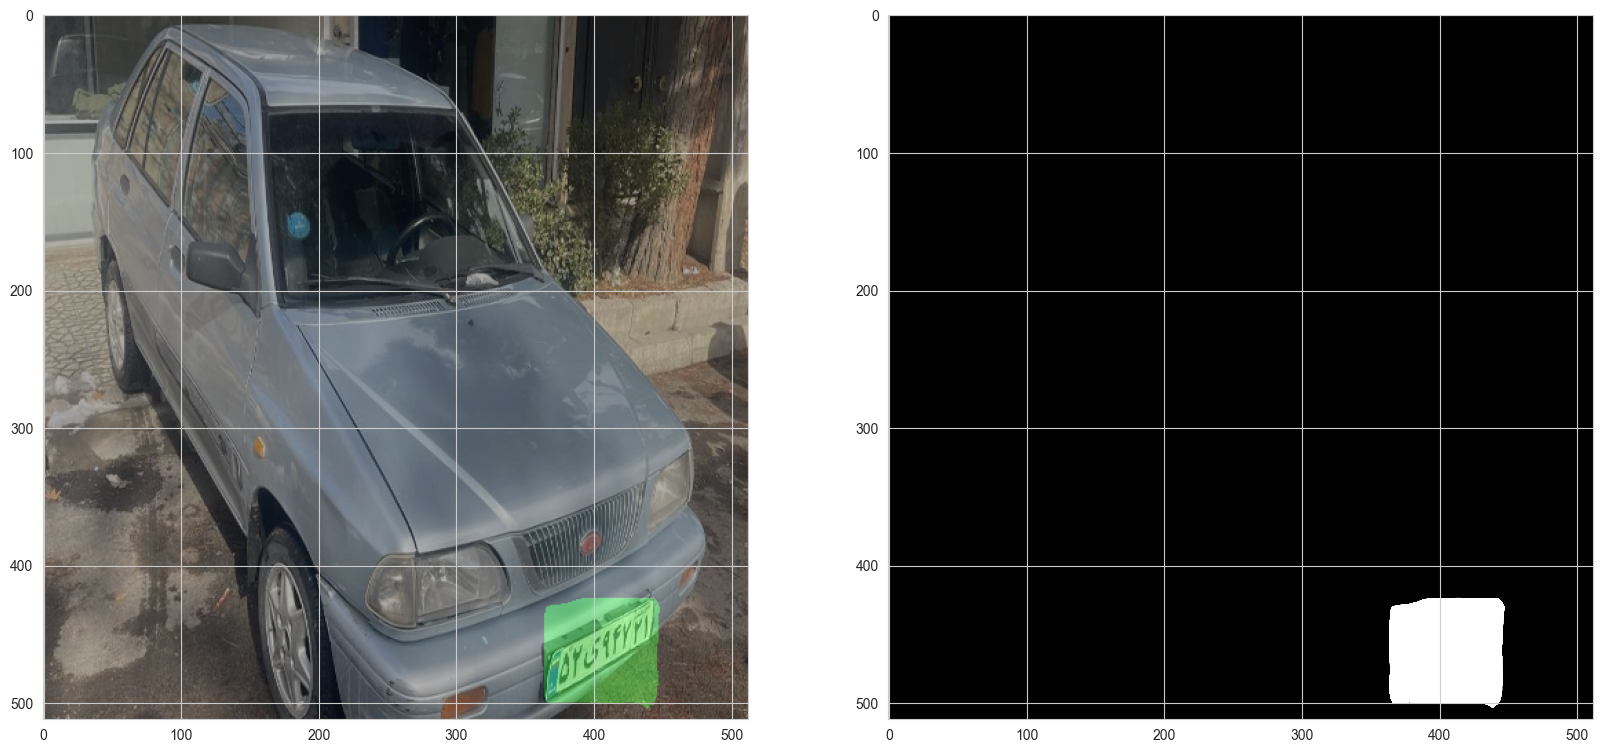

In [8]:
transforms = albu.Compose([
    albu.Resize(height=512, width=512),
    albu.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        max_pixel_value=255.0,
        always_apply=False,
        p=1.0
    ),
    ToTensorV2()
])

image = jpeg.JPEG('../dataset/single_COCO/950.jpg').decode()
out = transforms(
    image=image
)
image = out["image"]

pr_mask = new_model(image.to(DEVICE).unsqueeze(0))
print(pr_mask.shape)
pr_mask = (pr_mask.squeeze().cpu().detach().numpy().round())
print(pr_mask.shape)

test_image = self_augs.denormalize(self_augs.tensor_to_cv_image(image))
green_masks = np.zeros(test_image.shape, dtype=np.uint8)
valid_area = np.argwhere(pr_mask > 0)
green_masks[valid_area[:,0], valid_area[:,1], 1] = 255
img_add = cv2.addWeighted(test_image, 0.7, green_masks, 0.3, 0)
        
plt.rcParams['figure.figsize'] = [20, 10]
f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(img_add, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(pr_mask, cmap='gray', vmin=0, vmax=1)
# axarr[2].imshow(pr_mask, cmap='gray', vmin=0, vmax=1)


In [9]:
dummy_input = torch.rand(1, 3, 512, 512, device=DEVICE)
torch.onnx.export(
    new_model,
    dummy_input,
    ONNX_MODEL_NAME,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes = {'input': [0], 'output': [0]}, # динамический батч, но можно и статический
)

In [10]:
# проверяем, что модель конвертнулась успешно
onnx_model = onnx.load(ONNX_MODEL_NAME)
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph main_graph (
  %input[FLOAT, input_dynamic_axes_1x3x512x512]
) initializers (
  %_model.decoder.p5.weight[FLOAT, 256x2048x1x1]
  %_model.decoder.p5.bias[FLOAT, 256]
  %_model.decoder.p4.skip_conv.weight[FLOAT, 256x1024x1x1]
  %_model.decoder.p4.skip_conv.bias[FLOAT, 256]
  %_model.decoder.p3.skip_conv.weight[FLOAT, 256x512x1x1]
  %_model.decoder.p3.skip_conv.bias[FLOAT, 256]
  %_model.decoder.p2.skip_conv.weight[FLOAT, 256x256x1x1]
  %_model.decoder.p2.skip_conv.bias[FLOAT, 256]
  %_model.decoder.seg_blocks.0.block.0.block.0.weight[FLOAT, 128x256x3x3]
  %_model.decoder.seg_blocks.0.block.1.block.0.weight[FLOAT, 128x128x3x3]
  %_model.decoder.seg_blocks.0.block.2.block.0.weight[FLOAT, 128x128x3x3]
  %_model.decoder.seg_blocks.1.block.0.block.0.weight[FLOAT, 128x256x3x3]
  %_model.decoder.seg_blocks.1.block.1.block.0.weight[FLOAT, 128x128x3x3]
  %_model.decoder.seg_blocks.2.block.0.block.0.weight[FLOAT, 128x256x3x3]
  %_model.decoder.seg_blocks.3.block.0.block.0.weight[FLOAT, 128x2

In [12]:
# Доступные провайдеры, на которых можно выполнять вычисления
print(ort.get_available_providers())

['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'AzureExecutionProvider', 'CPUExecutionProvider']


In [13]:
# Инициализируем сессию

# При инициализации сессии можно указать несколько провайдеров. Это может быть полезно, если хотим запускать код
# на разных машинах. Например на машине с GPU у нас сработает CUDAExecutionProvider,
# а на машине без GPU CPUExecutionProvider
providers = [
    # 'CUDAExecutionProvider',
    'CPUExecutionProvider',
]

ort_session = ort.InferenceSession(
    ONNX_MODEL_NAME,
    providers=providers
)

print(f'{[input_.name for input_ in ort_session.get_inputs()]}')
print(f'{[output_.name for output_ in ort_session.get_outputs()]}')

['input']
['output']


In [14]:
def onnx_preprocessing(
    image,
    image_size=(224, 224)
):
    """
    Convert numpy-image to array for inference ONNX Runtime model.
    """

    # resize
    image = cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_LINEAR)

    # normalize
    mean = np.array((0.485, 0.456, 0.406), dtype=np.float32) * 255.0
    std = np.array((0.229, 0.224, 0.225), dtype=np.float32) * 255.0
    denominator = np.reciprocal(std, dtype=np.float32)
    image = image.astype(np.float32)
    image -= mean
    image *= denominator

    # transpose
    image = image.transpose((2, 0, 1))[None]
    return image

In [15]:
# готовим входной тензор
BATCH_SIZE = 1
image = jpeg.JPEG('../dataset/single_COCO/950.jpg').decode()
onnx_input = onnx_preprocessing(image, image_size=(512, 512))
onnx_input = np.concatenate([onnx_input] * BATCH_SIZE)

ort_inputs = {ort_session.get_inputs()[0].name: onnx_input}
print(list(ort_inputs.keys()))

['input']


In [24]:
# выполняем инференс ONNX Runtime
ort_outputs = ort_session.run(None, ort_inputs)[0]
print(ort_outputs.shape)

pr_mask = (ort_outputs.squeeze().round())
print(pr_mask.shape)

(1, 1, 512, 512)
(512, 512)


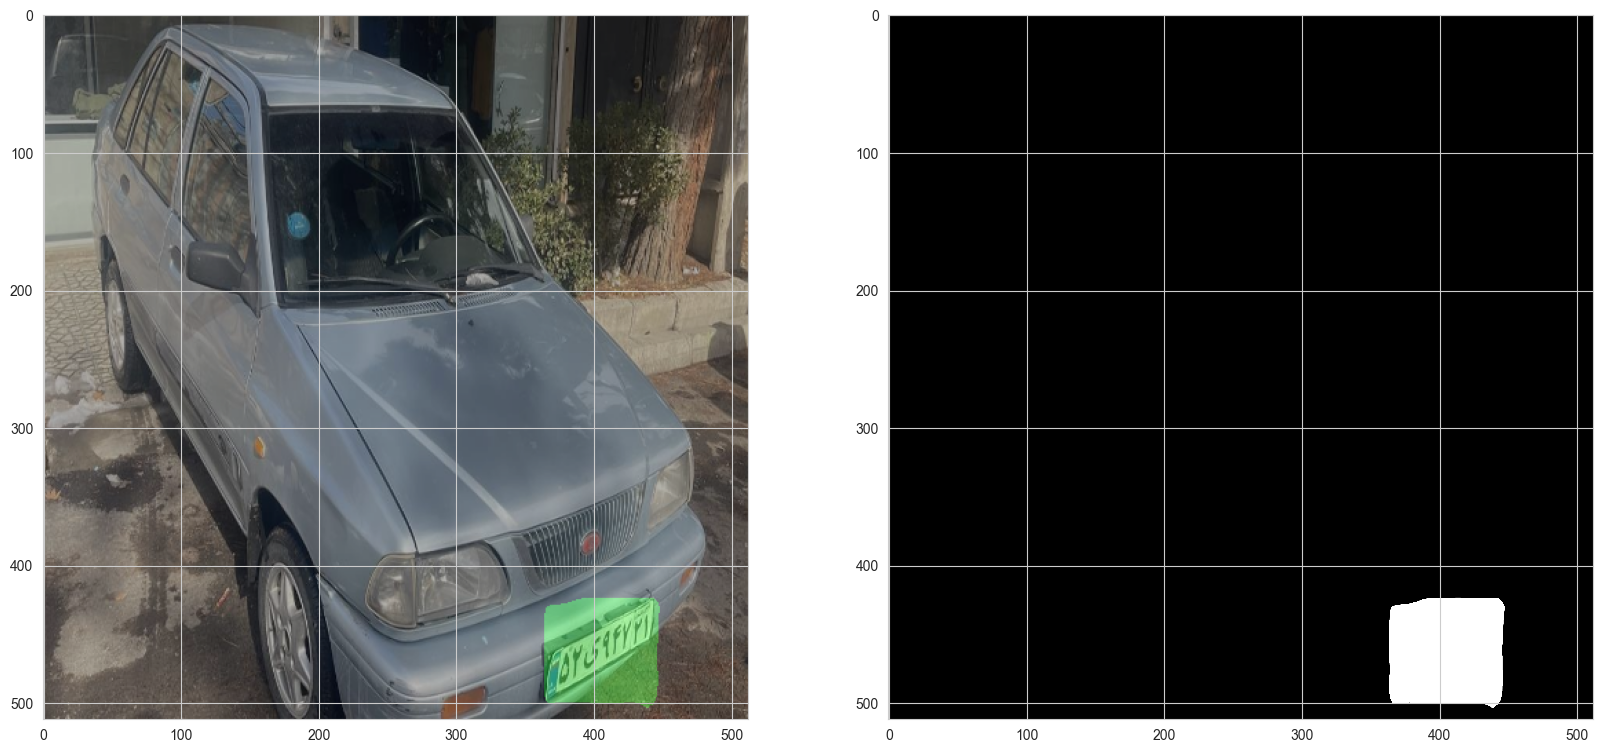

In [27]:
# resize
test_image = cv2.resize(image.copy(), (512,512), interpolation=cv2.INTER_LINEAR)

green_masks = np.zeros(test_image.shape, dtype=np.uint8)
valid_area = np.argwhere(pr_mask > 0)
green_masks[valid_area[:,0], valid_area[:,1], 1] = 255
img_add = cv2.addWeighted(test_image, 0.7, green_masks, 0.3, 0)
        
plt.rcParams['figure.figsize'] = [20, 10]
f, axarr = plt.subplots(1, 2) 

axarr[0].imshow(img_add, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(pr_mask, cmap='gray', vmin=0, vmax=1)

In [32]:
# Crop plate
green_masks[:, :, 2].shape

(512, 512)

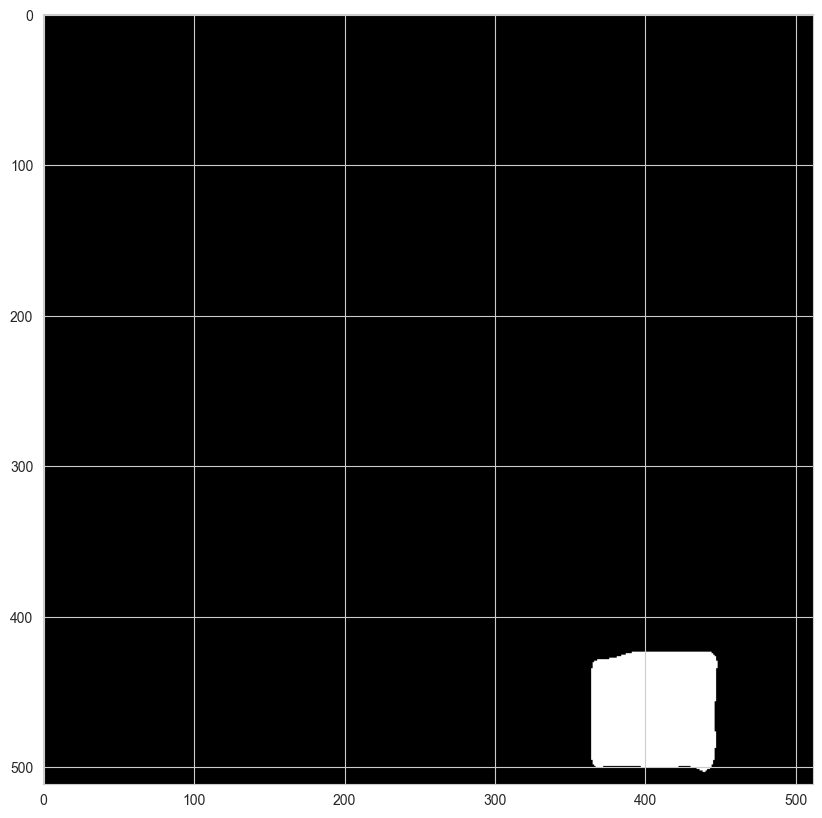

In [35]:
plt.imshow(green_masks[:, :, 1], cmap='gray')

In [36]:
np.where(green_masks[:, :, 1] == 255)

(array([424, 424, 424, ..., 502, 503, 503]),
 array([391, 392, 393, ..., 440, 438, 439]))

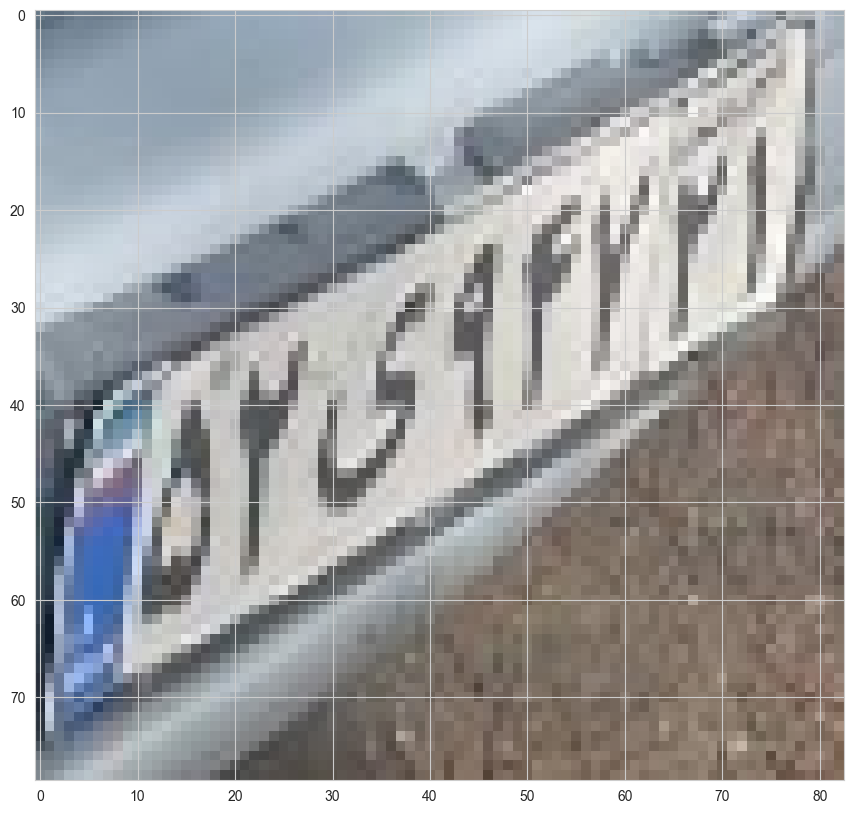

In [37]:
# Cropping an image
indexes = np.where(green_masks[:, :, 1] == 255)
x_min = indexes[0].min()
x_max = indexes[0].max()
y_min = indexes[1].min()
y_max = indexes[1].max()
plt.imshow(test_image[x_min:x_max, y_min:y_max, :])